# Thyroid Classification Analysis

# Imports

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

# Functions

In [52]:
def null_duplicate_check(df):
  print(f"Null Values Amount: {df.isna().sum()}")
  print(f"Duplicate Values Amount: {df.duplicated().sum()}")
  
def check_class_imbalance(target):
  
  target = np.array(target)
  
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 8))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 8))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Classes")
  plt.ylabel("Counts")
  plt.show()

def plot_model_performance(df, y, axis):
  
  fig, ax = plt.subplots(figsize=(15,8))
  df.plot.bar(x="Model",y=y, ax=ax)
  ax.set_xlabel("Model")
  ax.set_ylabel(axis)
  ax.set_title("Model Performance Comparison")
  
  ax.legend(y)
  ax.grid(True)
  plt.xticks(rotation=45)
  plt.show()

def create_confusion_matrix(model_name, y_test, y_test_pred, data_type):
  cm = confusion_matrix(y_test, y_test_pred)
  report = classification_report(y_test, y_test_pred)
  print(report)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
  plt.title(f"Confusion Matrix for: {model_name}-{data_type}")
  plt.xlabel("True Labels")
  plt.ylabel("Predictions")
  plt.show()
  
  

def create_column_transformer(numeric_features, categorical_features, ordinal_features):
  
  numeric_cols = numeric_features.columns
  categorical_cols = categorical_features.columns
  ordinal_cols = ordinal_features.columns
  
  numeric_transformer = Pipeline(
    steps=[ 
           ("scaler", StandardScaler()), 
           ("powertranformer", PowerTransformer())
           ]
  )
  
  categorical_tranformer = Pipeline(
    steps=[
      ("one_hot_encoder", OneHotEncoder())
    ]
  )
  
  ordinal_tranformer = Pipeline(
    steps=[
      ("ordinal", OrdinalEncoder())
    ]
  )
  
  preprocessor = ColumnTransformer(
    transformers=[
      ("num", numeric_transformer, numeric_cols),
      ("cat", categorical_tranformer, categorical_cols),
      ("ord", ordinal_tranformer, ordinal_cols)
    ]
  )
  
  return preprocessor

def create_pipeline(preprocessor, model, metric_name=None, kbest=None):
  steps = [("preprocessor", preprocessor), ("model", model)]
  
  if kbest:
    steps.insert(1, (metric_name, kbest))
  return Pipeline(steps=steps)

def create_sampling_pipeline(preprocessor, sample, model):
  steps = [("preprocessor", preprocessor), ("sampled", sample), ("model", model)]
  
  return imbPipeline(steps)

def evaluate_model(X, y, model):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  metric = make_scorer(f1_score, average="micro")
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
  }
  
  return [models[model_name] for model_name in names]

def test_selected_models(preprocessor, models, model_names, X, y):
  
  model_performance = []
  
  for i in range(len(model_names)):
    model, model_name = models[i], model_names[i]
    pipeline = create_pipeline(preprocessor, model)
    scores = evaluate_model(X, y, pipeline)
    model_performance.append({
      "Model": model_name,
      "Mean": round(np.mean(scores),3),
      "STD":np.round(np.std(scores),3)
    })
  
  model_performance_df = pd.DataFrame(model_performance)
  model_performance_df = model_performance_df.sort_values(by="Mean", ascending=False)
  plot_model_performance(model_performance_df, ["Mean", "STD"], "Mean")
  print(model_performance_df)
  
def get_over_sampling_methods(model_names):
  
  sampling_models = {
    "SMOTE": SMOTE(),
    "ADASYN": ADASYN(),
    "BL-SMOTE": BorderlineSMOTE(),
    "KNN-SMOTE": SMOTE(k_neighbors=5)
  }
  
  return [sampling_models[model_name] for model_name in model_names]

def test_sampled_selected_models(preprocessor, model_names, models, sampling_names, sampling_models, X, y):
  
  model_performance = []
  
  for idx in range(len(sampling_models)):
    sampling_name, sampling_model = sampling_names[idx], sampling_models[idx]
    for idx2 in range(len(models)):
      model_name, model = model_names[idx2], models[idx2]
      sampling_pipeline = create_sampling_pipeline(preprocessor, sampling_model, model)
      scores= evaluate_model(X,y,sampling_pipeline)
      model_performance.append({
      "Model": model_name + " " + sampling_name,
      "Mean": round(np.mean(scores),3),
      "STD":np.round(np.std(scores),3)
    })
  
  model_performance_df = pd.DataFrame(model_performance)
  model_performance_df = model_performance_df.sort_values(by="Mean", ascending =False).reset_index()
  plot_model_performance(model_performance_df, ["Mean", "STD"], "Mean")
  print(model_performance_df)

def test_predictions(preprocessor, model_names, models, X, y, sampling=None, sample=None):
  
  model_performance = []
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
  
  for i in range(len(models)):
    model_name, model = model_names[i], models[i]
    
    if sampling:
      model = create_sampling_pipeline(preprocessor, sample, model)
    else:
      model = create_pipeline(preprocessor, model)
  
    model.fit(X_train, y_train)
    
    y_pred_val = model.predict(X_val)
    y_val_acc = accuracy_score(y_val, y_pred_val)
    y_val_f1 = f1_score(y_val, y_pred_val)
    
    y_pred_test = model.predict(X_test)
    y_test_acc = accuracy_score(y_test, y_pred_test)
    y_test_f1 = f1_score(y_test, y_pred_test)
    
    # Confusion Matrix for Testing Data
    create_confusion_matrix(model_name, y_test, y_pred_test, "Test Dataset")
    
    model_performance.append({
      "Model": model_name,
      "Test Accuracy": y_test_acc,
      "Validation Accuracy": y_val_acc,
      "Test-F1-Score": y_test_f1,
      "Val-F1-Score": y_val_f1,
    })
  
  model_performance_df = pd.DataFrame(model_performance).sort_values(by="Test Accuracy", ascending=False).reset_index()
  print(model_performance_df)
  

# EDA Analysis

In [16]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,72,M,Yes,Yes,Yes,Euthyroid,Single nodular goiter-right,Right,Papillary,Uni-Focal,High,T4b,N1b,M1,IVB,Biochemical Incomplete,Yes
379,81,M,Yes,No,Yes,Euthyroid,Multinodular goiter,Extensive,Papillary,Multi-Focal,High,T4b,N1b,M1,IVB,Structural Incomplete,Yes
380,72,M,Yes,Yes,No,Euthyroid,Multinodular goiter,Bilateral,Papillary,Multi-Focal,High,T4b,N1b,M1,IVB,Structural Incomplete,Yes
381,61,M,Yes,Yes,Yes,Clinical Hyperthyroidism,Multinodular goiter,Extensive,Hurthel cell,Multi-Focal,High,T4b,N1b,M0,IVA,Structural Incomplete,Yes


# Check for Nulls and Dupes

In [17]:
null_duplicate_check(df)

Null Values Amount: Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
Recurred                0
dtype: int64
Duplicate Values Amount: 19


In [18]:
df.drop_duplicates(inplace=True)

# Check for class imbalance

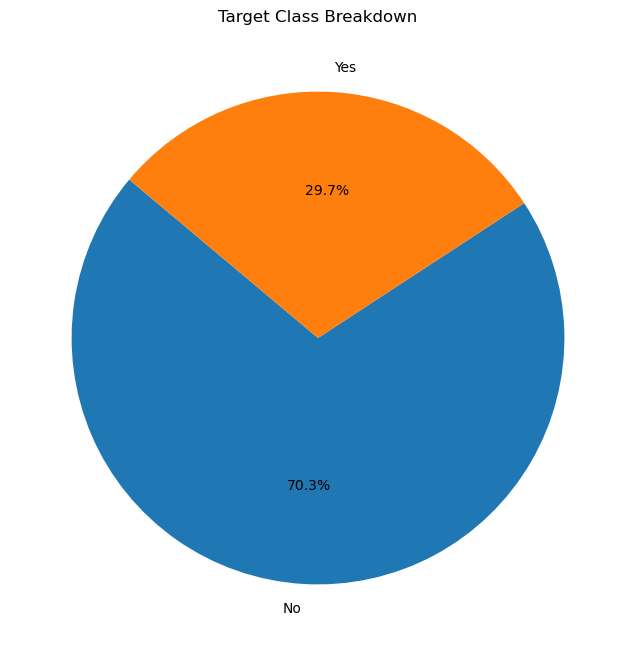

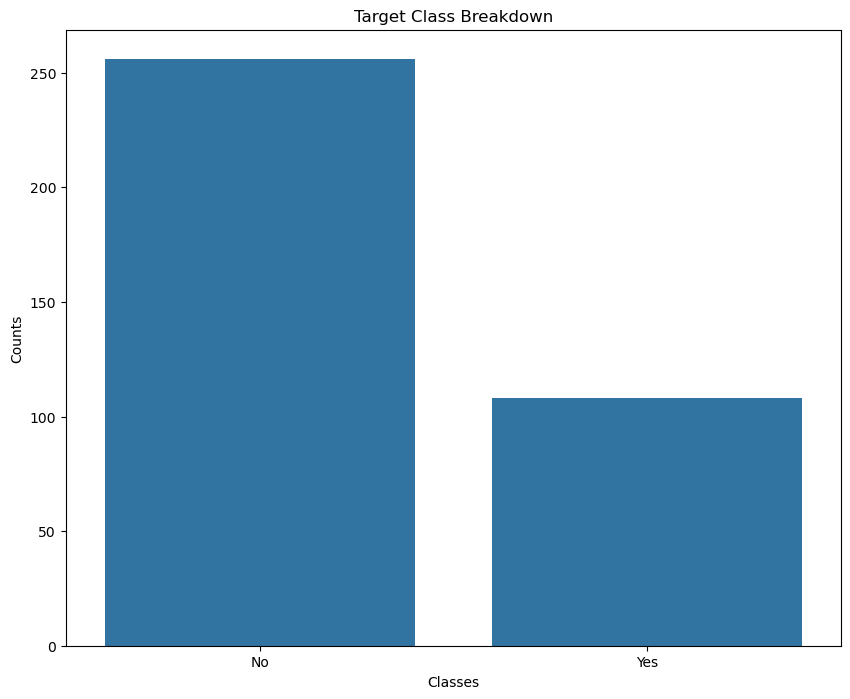

In [19]:
check_class_imbalance(df["Recurred"])

# Classes are imbalanced which means we will have to use some sampling techniques in order to address the imabalance

In [20]:
df.dtypes

Age                      int64
Gender                  object
Smoking                 object
Hx Smoking              object
Hx Radiothreapy         object
Thyroid Function        object
Physical Examination    object
Adenopathy              object
Pathology               object
Focality                object
Risk                    object
T                       object
N                       object
M                       object
Stage                   object
Response                object
Recurred                object
dtype: object

# All but one column is an integer value which means, we will have to do some preprocessing in order to format the data on our models.

In [21]:
categorical_features, numeric_features = df.select_dtypes(include=["object"]).drop("Recurred", axis=1), df.select_dtypes(include="int64")

# We have ordinal columns and we also have catergorical columns, we need to address this in our processing stages. The only issue is that I don't know which columns are categorical and ordinal. We will have to guess.

In [22]:
ordinal_features = categorical_features[["Stage", "Response", "Risk"]]

In [23]:
categorical_features.drop(["Stage", "Response", "Risk"], axis=1, inplace=True)

# Create Column Transformer

In [24]:
preprocessor = create_column_transformer(numeric_features, categorical_features, ordinal_features)

# Separate Feature columns

In [25]:
X, y = df.drop("Recurred", axis=1), df["Recurred"]

# Label encode Target Class

In [26]:
encoder = LabelEncoder()

y = encoder.fit_transform(y)

# We will score our models based on F1 Score giving equal balance to both classes given this is a serious health condition

# Baseline Model

In [27]:
model = DummyClassifier(strategy="constant", constant=1)
pipeline = create_pipeline(preprocessor, model)
scores = evaluate_model(X, y, pipeline)

scores = evaluate_model(X, y, pipeline)
print(f"Mean: {round(np.mean(scores),3)}, STD: {round(np.std(scores),3)}")

Mean: 0.297, STD: 0.01


# Advanced Model Metrics

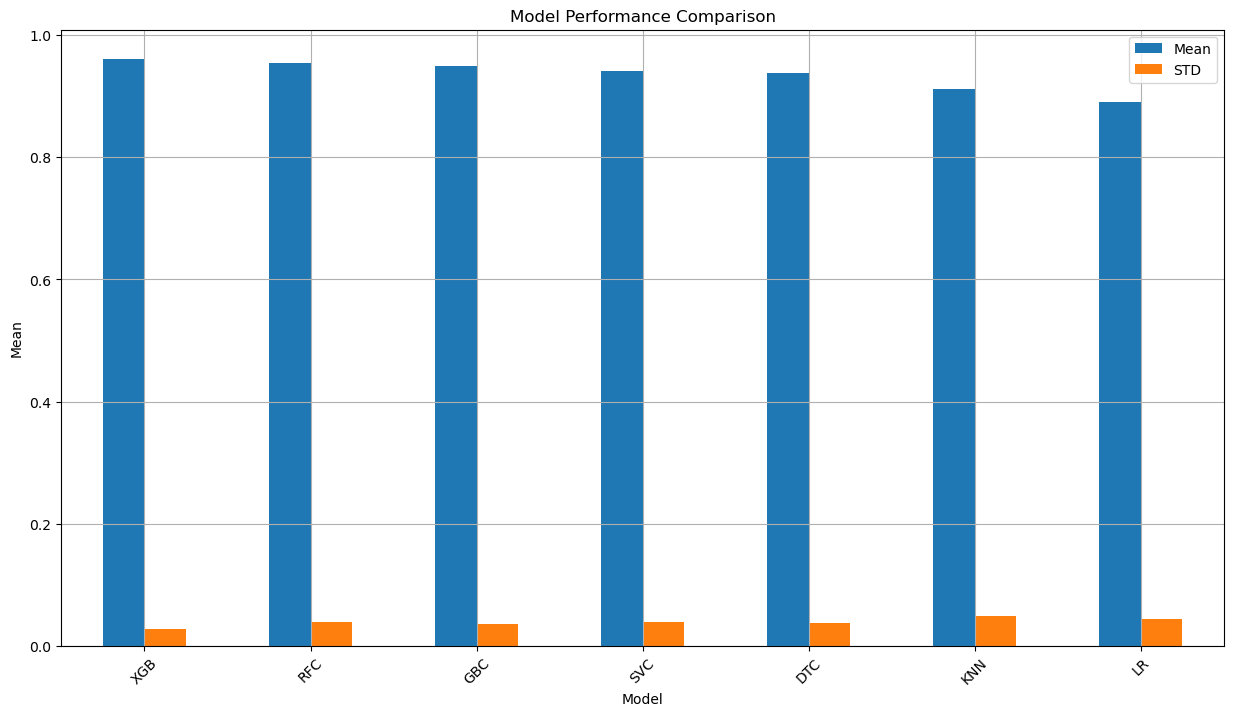

  Model   Mean    STD
5   XGB  0.961  0.028
3   RFC  0.955  0.039
4   GBC  0.950  0.035
2   SVC  0.941  0.038
6   DTC  0.938  0.037
0   KNN  0.912  0.048
1    LR  0.891  0.044


In [47]:
model_names = ["KNN", "LR", "SVC", "RFC", "GBC", "XGB", "DTC"]
models = grab_selected_models(model_names)
test_selected_models(preprocessor, models, model_names, X, y)

# We have acheived some high scores, however, our data is imbalanced so these scores could be considered irrelevant. We will have to test out over sampling methods and see which methods work the best. Let's see how our models performs on testing and validation datasets.

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.91      0.95        11

    accuracy                           0.97        37
   macro avg       0.98      0.95      0.97        37
weighted avg       0.97      0.97      0.97        37



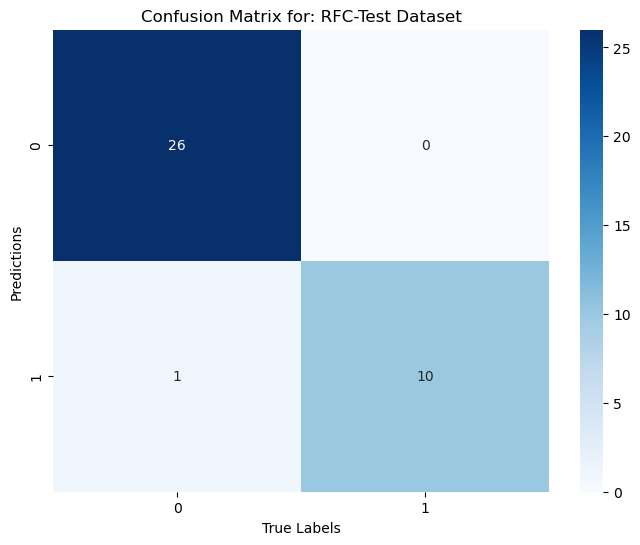

              precision    recall  f1-score   support

           0       1.00      0.88      0.94        26
           1       0.79      1.00      0.88        11

    accuracy                           0.92        37
   macro avg       0.89      0.94      0.91        37
weighted avg       0.94      0.92      0.92        37



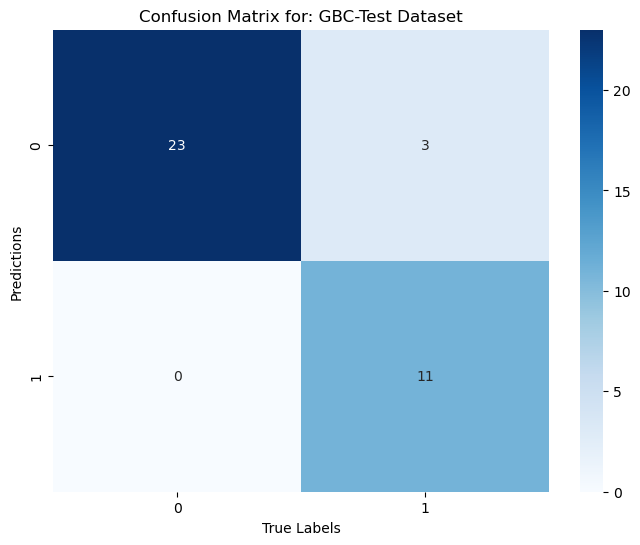

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.85      1.00      0.92        11

    accuracy                           0.95        37
   macro avg       0.92      0.96      0.94        37
weighted avg       0.95      0.95      0.95        37



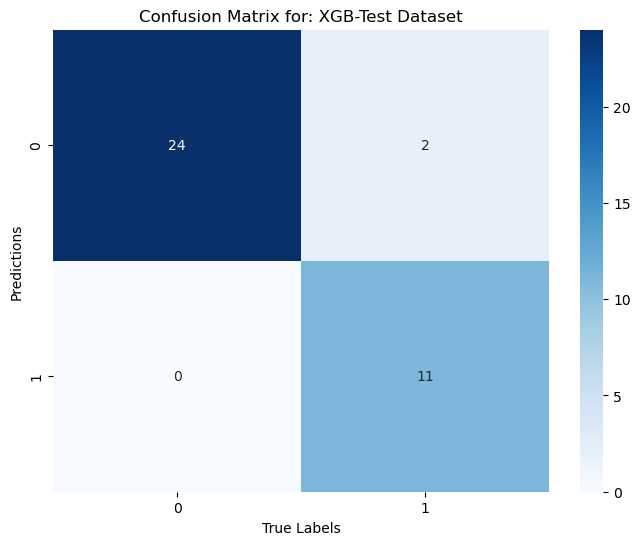

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.85      1.00      0.92        11

    accuracy                           0.95        37
   macro avg       0.92      0.96      0.94        37
weighted avg       0.95      0.95      0.95        37



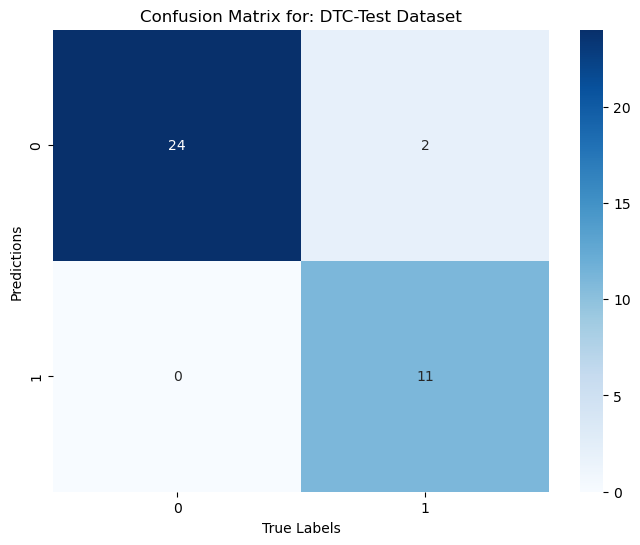

   index Model  Test Accuracy  Validation Accuracy  Test-F1-Score  \
0      0   RFC       0.972973             0.916667       0.952381   
1      2   XGB       0.945946             0.944444       0.916667   
2      3   DTC       0.945946             0.916667       0.916667   
3      1   GBC       0.918919             0.944444       0.880000   

   Val-F1-Score  
0      0.857143  
1      0.909091  
2      0.869565  
3      0.909091  


In [53]:
model_names = ["RFC", "GBC", "XGB", "DTC"]
models = grab_selected_models(model_names)

test_predictions(preprocessor, model_names, models, X, y)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        26
           1       0.73      0.73      0.73        11

    accuracy                           0.84        37
   macro avg       0.81      0.81      0.81        37
weighted avg       0.84      0.84      0.84        37



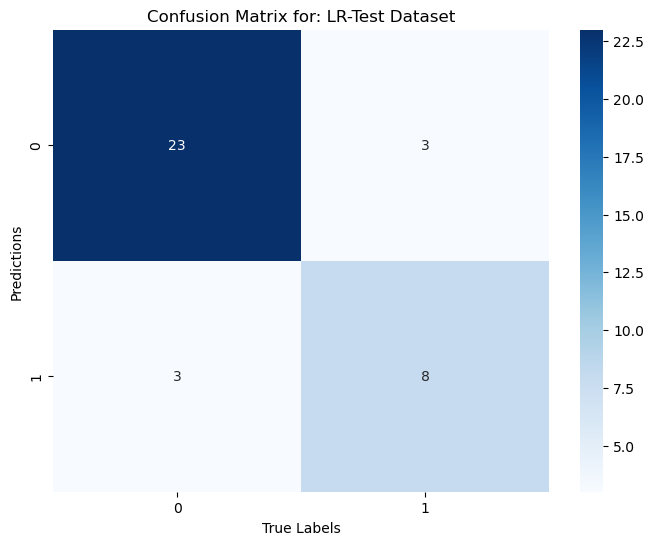

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       0.91      0.91      0.91        11

    accuracy                           0.95        37
   macro avg       0.94      0.94      0.94        37
weighted avg       0.95      0.95      0.95        37



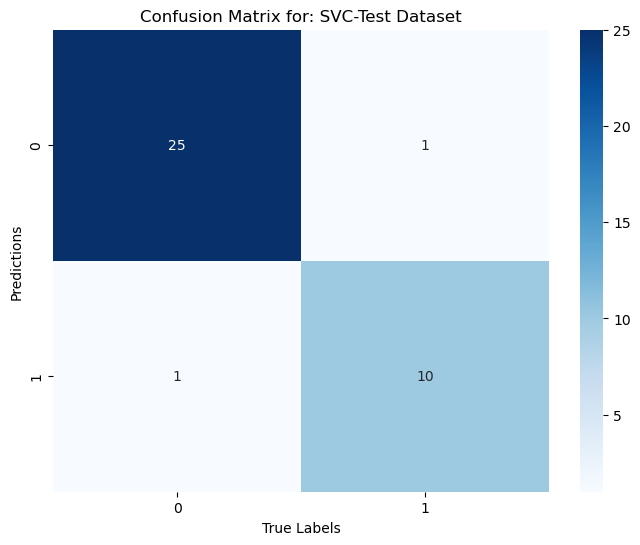

              precision    recall  f1-score   support

           0       0.89      0.96      0.93        26
           1       0.89      0.73      0.80        11

    accuracy                           0.89        37
   macro avg       0.89      0.84      0.86        37
weighted avg       0.89      0.89      0.89        37



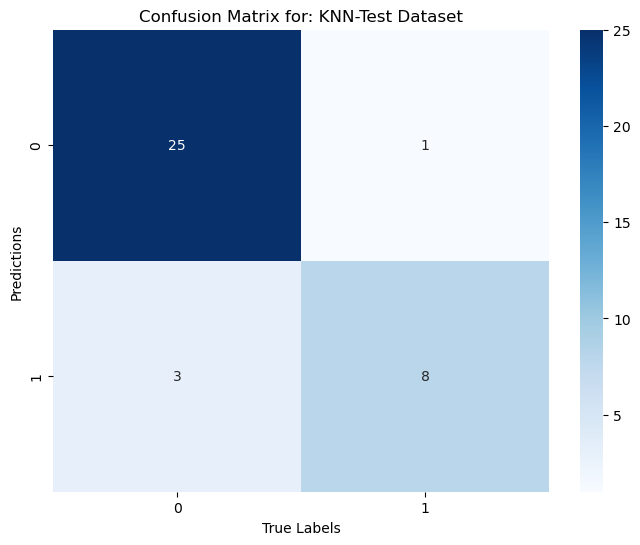

   index Model  Test Accuracy  Validation Accuracy  Test-F1-Score  \
0      1   SVC       0.945946             0.888889       0.909091   
1      2   KNN       0.891892             0.888889       0.800000   
2      0    LR       0.837838             0.916667       0.727273   

   Val-F1-Score  
0      0.818182  
1      0.800000  
2      0.857143  


In [54]:
model_names = ["LR", "SVC", "KNN"]
models = grab_selected_models(model_names)

test_predictions(preprocessor, model_names, models, X, y)

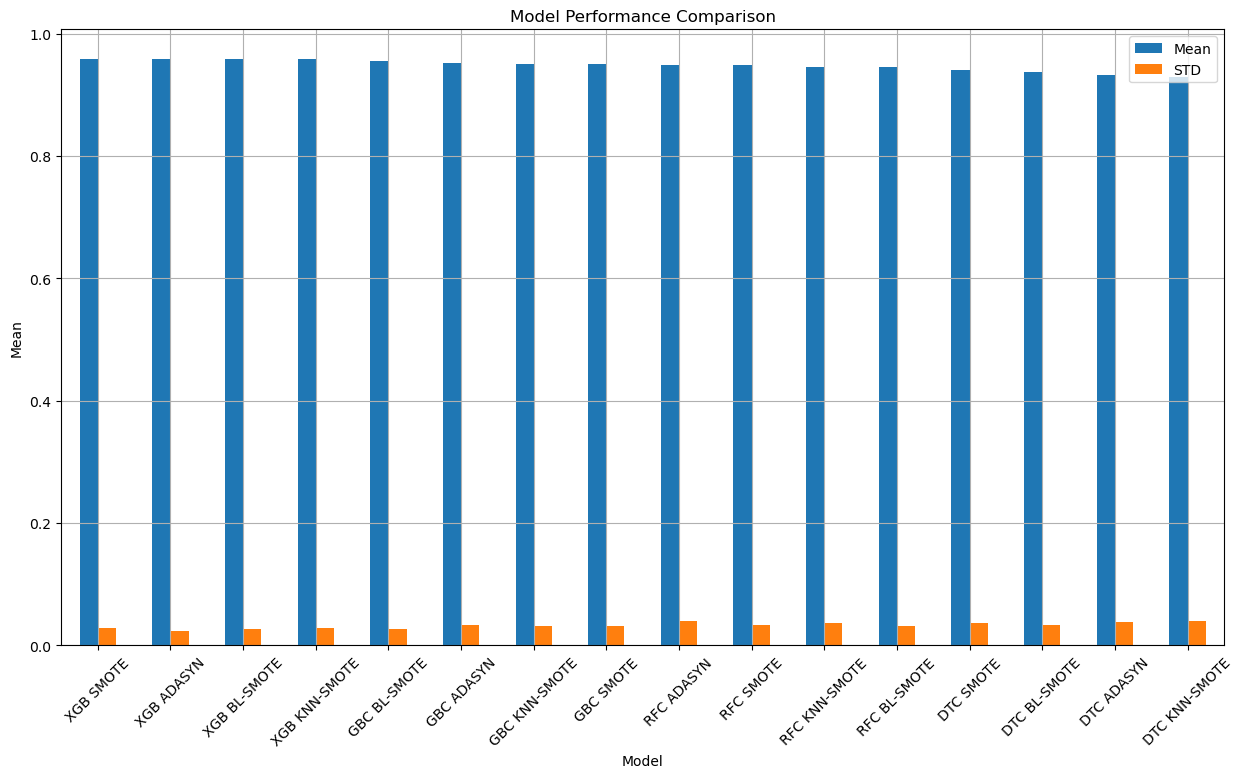

    index          Model   Mean    STD
0       3      XGB SMOTE  0.959  0.028
1       7     XGB ADASYN  0.959  0.023
2      11   XGB BL-SMOTE  0.958  0.027
3      15  XGB KNN-SMOTE  0.958  0.028
4      10   GBC BL-SMOTE  0.955  0.027
5       6     GBC ADASYN  0.952  0.033
6      14  GBC KNN-SMOTE  0.951  0.032
7       2      GBC SMOTE  0.950  0.031
8       4     RFC ADASYN  0.949  0.040
9       0      RFC SMOTE  0.948  0.034
10     12  RFC KNN-SMOTE  0.946  0.037
11      8   RFC BL-SMOTE  0.945  0.031
12      1      DTC SMOTE  0.940  0.036
13      9   DTC BL-SMOTE  0.937  0.033
14      5     DTC ADASYN  0.932  0.039
15     13  DTC KNN-SMOTE  0.929  0.040


In [48]:
sampling_names=["SMOTE", "ADASYN", "BL-SMOTE", "KNN-SMOTE"]
model_names = ["RFC", "DTC", "GBC", "XGB"]
models = grab_selected_models(model_names)
sampling_models = get_over_sampling_methods(sampling_names)

test_sampled_selected_models(preprocessor, model_names, models, sampling_names, sampling_models, X, y)

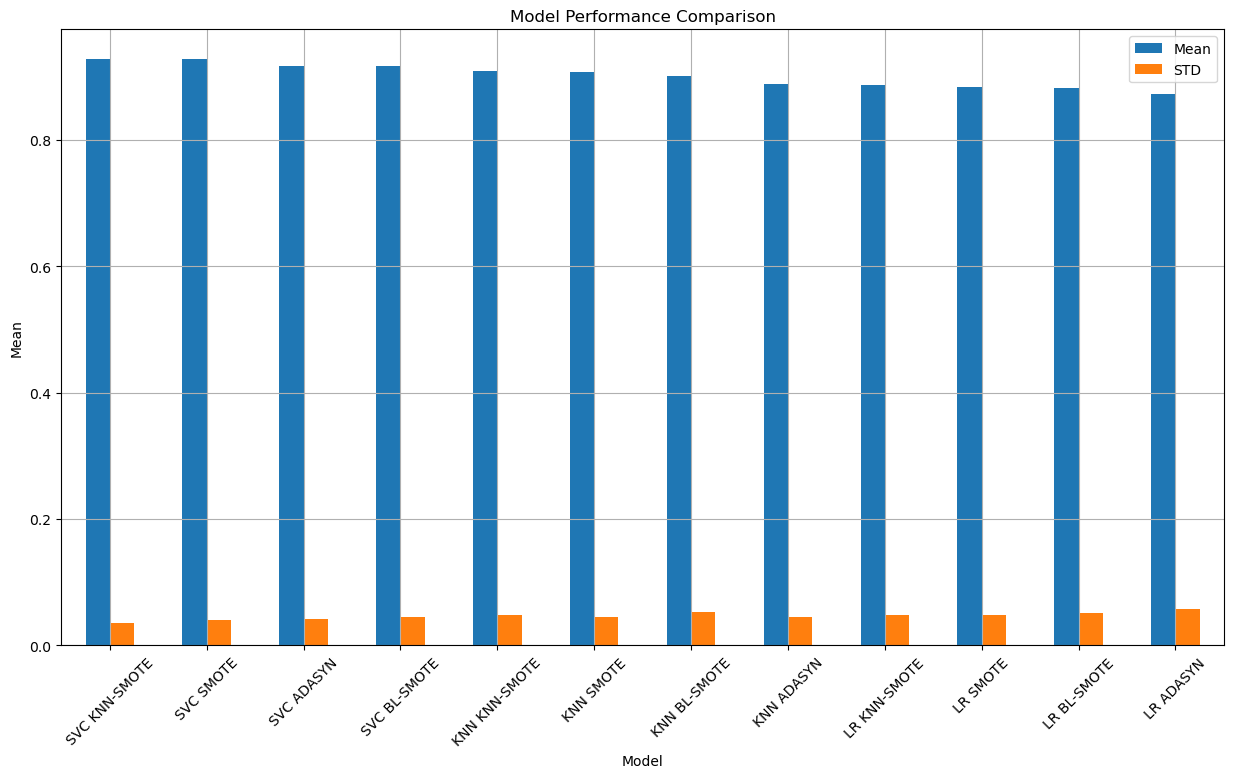

    index          Model   Mean    STD
0      10  SVC KNN-SMOTE  0.928  0.035
1       1      SVC SMOTE  0.927  0.040
2       4     SVC ADASYN  0.916  0.042
3       7   SVC BL-SMOTE  0.916  0.045
4      11  KNN KNN-SMOTE  0.909  0.048
5       2      KNN SMOTE  0.907  0.045
6       8   KNN BL-SMOTE  0.900  0.053
7       5     KNN ADASYN  0.888  0.045
8       9   LR KNN-SMOTE  0.886  0.048
9       0       LR SMOTE  0.884  0.048
10      6    LR BL-SMOTE  0.882  0.052
11      3      LR ADASYN  0.872  0.058


In [49]:
model_names = ["LR", "SVC", "KNN"]
models = grab_selected_models(model_names)
test_sampled_selected_models(preprocessor, model_names, models, sampling_names, sampling_models, X, y)